# Tutorial II Hierarchical Waveform Clustering: extract most relevant features with ICA

This is the second notebook of hierarchical waveform clustering. After calculating the scattering coefficients in the first notebook, this second notebook will extract the most relevant features with an indepedent component analysis (ICA).

In [1]:
import numpy as np
import os
import pickle
import glob
import nmmn.plots

from sklearn.decomposition import FastICA
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation
from scipy.signal import medfilt

## Load scattering coefficients

First, we load the scattering coefficients and reshape them for the `FastICA` model of the `scikit-learn` package. In the first tutorial we saved the first order scattering coefficients with a shape like: **n_times x n_channel x n_first_order_wavelets**. The second order scattering coefficients have the shape **n_times x n_channel x n_first_order_wavelets x n_second_order_wavelets**. <br>
For the `FastICA` we will vectorize the first and second order scattering coefficients of all channels and create a 2D array.

In [2]:
def load_vectorized_scat_coef():
    
    """Load and reshape the scattering coefficients.
    times: np.array(n_times)
    scat_coef_vectorized: np.array(n_times, vectorized coefficients)
    """
    
    # LOAD DATA
    output_scatnet = np.load('example/scatnet_output.npz')
    scat_coef_0 = output_scatnet['scat_coef_0']
    scat_coef_1 = output_scatnet['scat_coef_1']
    times = output_scatnet['times']
    
    # RESHAPE THE SCATTERING COEFFICIENTS AND VECTORIZE THEM
    scat_coef_0_reshaped = scat_coef_0.reshape(scat_coef_0.shape[0],scat_coef_0.shape[1]*scat_coef_0.shape[2])
    scat_coef_1_reshaped = scat_coef_1.reshape(scat_coef_1.shape[0],scat_coef_1.shape[1]*scat_coef_1.shape[2]*scat_coef_1.shape[3])
    scat_coef_vectorized = np.hstack((scat_coef_0_reshaped,scat_coef_1_reshaped))
    
    scat_coef_vectorized = np.log(scat_coef_vectorized)
    
    return times, scat_coef_vectorized

In [3]:
times, scat_coef_vectorized = load_vectorized_scat_coef()

## Apply ICA-model to extract most relevant features
After loading and vectorzing the scattering coefficients, we can now apply `FastICA`. The model only needs to know how many features we want to extract, called `DIMENSIONS` below. The shape of `features` is then given by `DIMENSIONS` x n_times. <br>
The ICA model and its output are then saved for the other tutorials.

In [ ]:
DIMENSIONS = 10

model = FastICA(n_components=DIMENSIONS)
features = model.fit_transform(scat_coef_vectorized)

In [9]:
# SAVE THE FEATURES
np.save('example/features.npy',features)

# SAVE ICA MODEL IN PICKLE FILE
with open('example/ica_model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Let's have a look at the features in time and space

In [5]:
def demad(x, factor=10.0):
    """Normalize signal with median absolute deviation.
    
    Arguments
    ---------
    x: np.ndarray
        The input signal.
    factor: float, optional
        An additional normalization factor.
    
    Returns
    -------
    The data normalized with median absolute deviation.
    """
    mad = median_abs_deviation(x)
    return x / np.mean(mad) / factor

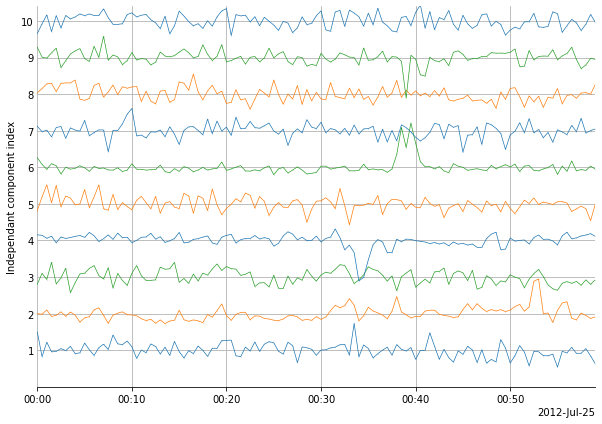

In [6]:
#features = latents
FACTOR=0.4
MEDFILT_KERNEL=1

# Show in time

# Preprocess
features = features.T
features = demad(features)
n_features, n_bins = features.shape

# Figure
fig, ax = plt.subplots(1, figsize=(10, 7))

# Show
for index, feature in enumerate(features):
    color = f"C{index % 3}"
    feature += index + 1
    feature_filtered = medfilt(feature, MEDFILT_KERNEL)
    ax.plot(times, feature, ".", ms=1, alpha=0.5, mew=0, color=color)
    ax.plot(times, feature_filtered, lw=0.7, color=color)

# Labels
ax.grid()
ax.set_ylim(0, n_features + FACTOR)
ax.set_yticks(np.arange(n_features) + 1)
ax.set_ylabel("Independant component index")

# Date labels
dateticks = mdates.AutoDateLocator()
datelabels = mdates.ConciseDateFormatter(dateticks)
ax.xaxis.set_major_locator(dateticks)
ax.xaxis.set_major_formatter(datelabels)
ax.set_xlim(times.min(), times.max())

# Remove borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis="y", length=0)

plt.show()

In [7]:
CMAP=nmmn.plots.wolframcmap()
NBINS=800

# Show in latent space

# Preprocess
features = features.T
features = demad(features)
n_features = features.shape[0] - 1

# Figure
figsize = 2 * [n_features]
gridspec_kw = dict(hspace=0.1, wspace=0.1)
fig, ax = plt.subplots(
    n_features,
    n_features,
    figsize=figsize,
    gridspec_kw=gridspec_kw,
    constrained_layout=False,
    sharex="col",
    sharey="row",
)

# Versus diagrams
for i in range(n_features):

    x = features[i]
    x_min, x_max = x.min(), x.max()
    x_bins = np.linspace(x_min, x_max, nbins)

    for j in range(0, n_features):

        y = features[j + 1]
        y_min, y_max = y.min(), y.max()
        y_bins = np.linspace(y_min, y_max, NBINS)

        # Lower triangular
        if j >= i:

            # Histogram
            counts, _, _ = np.histogram2d(x, y, (x_bins, y_bins))
            counts = counts.T
            counts[counts == 0] = 1e-4
            counts = np.log(counts)
            extent = [x_min, x_max, y_min, y_max]
            ax[j, i].imshow(
                counts, cmap=CMAP, extent=extent, aspect="auto"
            )
            ax[j, i].grid()
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].set_ylim(y_min, y_max)
            ax[j, i].set_xlim(x_min, x_max)

            # Style
            for side in ax[j, i].spines:
                ax[j, i].spines[side].set_visible(False)

        # Upper triangular
        else:
            ax[j, i].set_axis_off()

        # Labels
        if j == n_features - 1:
            ax[j, i].set_xlabel(f"Latent {i + 1}")
        if i == 0:
            ax[j, i].set_ylabel(f"Latent {j + 2}")

plt.show()


KeyboardInterrupt



Error in callback <function flush_figures at 0x7f84516e57e0> (for post_execute):



KeyboardInterrupt



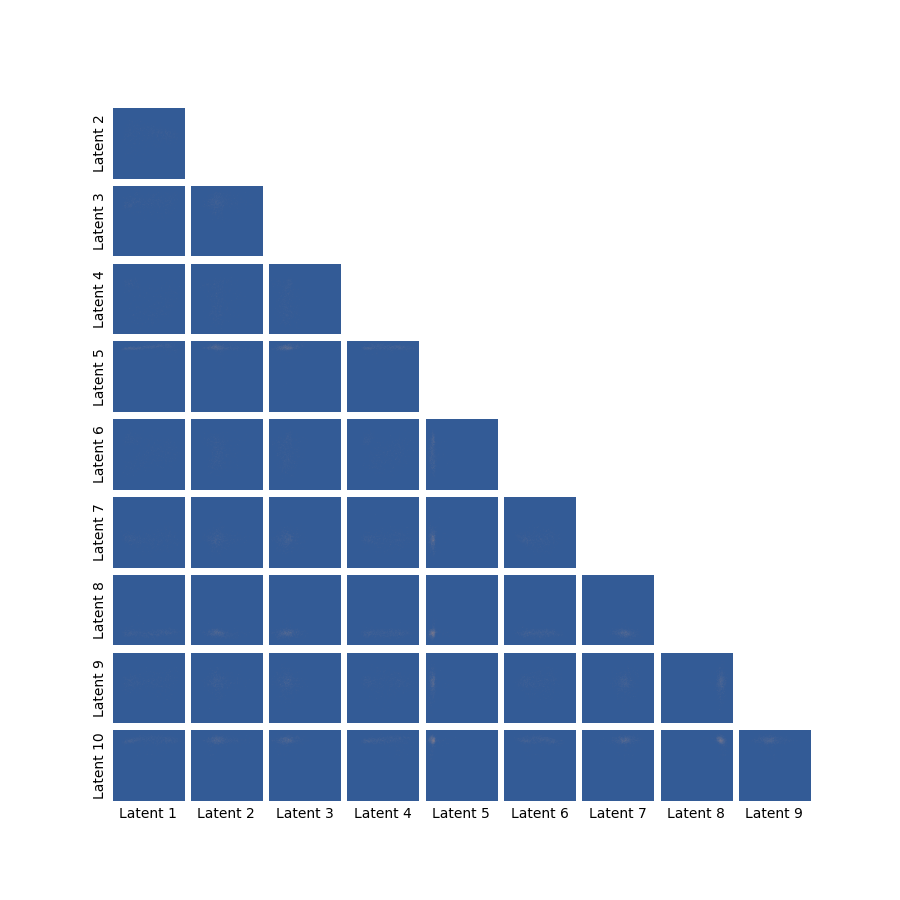